# Running LLM based classificaiton

In [ ]:
import json
import pandas as pd
import time
import os
import re
import datetime
import statistics
from tqdm.auto import tqdm
import backoff
import concurrent.futures
from openai import OpenAI, OpenAIError, RateLimitError
from openai import AzureOpenAI, APITimeoutError

# --------------------------
# Resumability Functions
# --------------------------

def create_processed_files_log(log_file="processed_files.json"):
    """Create a processed files log if it doesn't exist"""
    if not os.path.exists(log_file):
        with open(log_file, 'w') as f:
            json.dump({"processed_files": []}, f)
        print(f"Created new processed files log: {log_file}")

def get_processed_files(log_file="processed_files.json"):
    """Get list of files that have been already processed"""
    if not os.path.exists(log_file):
        create_processed_files_log(log_file)
        return []
    
    try:
        with open(log_file, 'r') as f:
            data = json.load(f)
        return data.get("processed_files", [])
    except Exception as e:
        print(f"Error reading processed files log: {e}")
        return []

def mark_file_as_processed(file_path, log_file="processed_files.json"):
    """Mark a file as processed in the log"""
    processed_files = get_processed_files(log_file)
    
    # Use basename to avoid path differences
    basename = os.path.basename(file_path)
    
    if basename not in processed_files:
        processed_files.append(basename)
        
        try:
            with open(log_file, 'w') as f:
                json.dump({"processed_files": processed_files}, f)
            print(f"Marked {basename} as processed")
        except Exception as e:
            print(f"Error updating processed files log: {e}")

# --------------------------
# API Client Classes
# --------------------------

class OpenRouterClient:
    def __init__(self, api_key, base_url="https://openrouter.ai/api/v1",
                 model_name=None, site_url=None, site_name=None):
        """
        Initialize the OpenRouterClient with your API key and settings.
        """
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.deployment_name = model_name
        self.extra_headers = {}
        if site_url:
            self.extra_headers["HTTP-Referer"] = site_url
        if site_name:
            self.extra_headers["X-Title"] = site_name
        self.total_cost = 0
        self.error_count = 0
        self.success_count = 0
        self.last_request_time = 0
        self.min_request_interval = 1.5  # Minimum seconds between requests

    @backoff.on_exception(
        backoff.expo,
        (RateLimitError, OpenAIError, TypeError, ValueError),
        max_tries=10,
        max_value=120,
        factor=2,
        jitter=None
    )
    def send_request(self, model_name, prompt, max_tokens=150, temperature=0, **kwargs):
        """
        Send a prompt to the OpenRouter API.
        """
        try:
            # Add rate limiting - enforce minimum time between requests
            current_time = time.time()
            time_since_last_request = current_time - self.last_request_time
            
            if time_since_last_request < self.min_request_interval:
                wait_time = self.min_request_interval - time_since_last_request
                time.sleep(wait_time)
                
            messages = [{"role": "user", "content": prompt}]
            response = self.client.chat.completions.create(
                model=self.deployment_name,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                n=1,
                extra_headers=self.extra_headers,
                **kwargs
            )
            if (not response or not response.choices or
                not response.choices[0].message.content):
                raise ValueError("Invalid response received from API")
            generated_text = response.choices[0].message.content.strip()
            self.success_count += 1
            
            # Update last request time
            self.last_request_time = time.time()
            
            return generated_text
        except Exception as e:
            self.error_count += 1
            # We'll explicitly handle rate limits with a longer sleep
            if "429" in str(e) or "rate limit" in str(e).lower():
                wait_time = 20  # Default wait time for rate limits
                print(f"Rate limit exceeded. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            raise e

    def get_total_cost(self):
        """Get the total accumulated cost of all API calls."""
        return self.total_cost  # OpenRouter doesn't provide token usage
    
    def get_success_rate(self):
        """Get the success rate as a percentage."""
        total_requests = self.success_count + self.error_count
        if total_requests == 0:
            return 0
        return (self.success_count / total_requests) * 100
    
    def verify_connection(self):
        """Verify that the client can connect and authenticate."""
        try:
            # Simple test message
            test_message = "Hello, this is a test message to verify the connection."
            self.send_request(self.deployment_name, test_message, max_tokens=10)
            return True, "Connection successful"
        except Exception as e:
            return False, f"Connection failed: {str(e)}"


class DeepSeekClient:
    def __init__(self, api_key, base_url="https://api.deepseek.com",
                 model_name="deepseek-chat"):
        """
        Initialize the DeepSeekClient with your API key and settings.
        """
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.deployment_name = model_name
        self.total_cost = 0
        self.error_count = 0
        self.success_count = 0
        self.last_request_time = 0
        self.min_request_interval = 1.5  # Minimum seconds between requests

    @backoff.on_exception(
        backoff.expo,
        (RateLimitError, OpenAIError, TypeError, ValueError),
        max_tries=10,
        max_value=120,
        factor=2,
        jitter=None
    )
    def send_request(self, model_name, prompt, max_tokens=150, temperature=0, **kwargs):
        """
        Send a prompt to the DeepSeek API.
        """
        try:
            # Add rate limiting - enforce minimum time between requests
            current_time = time.time()
            time_since_last_request = current_time - self.last_request_time
            
            if time_since_last_request < self.min_request_interval:
                wait_time = self.min_request_interval - time_since_last_request
                time.sleep(wait_time)
                
            messages = [
                {"role": "system", "content": "You are a helpful assistant"},
                {"role": "user", "content": prompt}
            ]
            response = self.client.chat.completions.create(
                model=self.deployment_name,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                n=1,
                **kwargs
            )
            if (not response or not response.choices or
                not response.choices[0].message.content):
                raise ValueError("Invalid response received from API")
            generated_text = response.choices[0].message.content.strip()
            self.success_count += 1
            
            # Update last request time
            self.last_request_time = time.time()
            
            return generated_text
        except Exception as e:
            self.error_count += 1
            # We'll explicitly handle rate limits with a longer sleep
            if "429" in str(e) or "rate limit" in str(e).lower():
                wait_time = 20  # Default wait time for rate limits
                print(f"Rate limit exceeded. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            raise e

    def get_total_cost(self):
        """Get the total accumulated cost of all API calls."""
        return self.total_cost  # DeepSeek doesn't provide token usage
    
    def get_success_rate(self):
        """Get the success rate as a percentage."""
        total_requests = self.success_count + self.error_count
        if total_requests == 0:
            return 0
        return (self.success_count / total_requests) * 100
    
    def verify_connection(self):
        """Verify that the client can connect and authenticate."""
        try:
            # Simple test message
            test_message = "Hello, this is a test message to verify the connection."
            self.send_request(self.deployment_name, test_message, max_tokens=10)
            return True, "Connection successful"
        except Exception as e:
            return False, f"Connection failed: {str(e)}"


class AzureOpenAIClient:
    def __init__(self, api_key, endpoint, deployment_name, api_version='2024-12-01-preview'):
        """
        Initialize the AzureOpenAIClient with the provided API key, endpoint, and deployment name.
        """
        self.client = AzureOpenAI(
            api_key=api_key,
            azure_endpoint=endpoint,
            api_version=api_version,
        )
        self.deployment_name = deployment_name
        self.total_cost = 0  # Track total cost
        self.error_count = 0
        self.success_count = 0
        self.last_request_time = 0  # Track time of last request for rate limiting
        self.min_request_interval = 1.5  # Minimum seconds between requests (adjust as needed)

    @backoff.on_exception(
        backoff.expo, 
        (RateLimitError, APITimeoutError, OpenAIError),
        max_tries=10,  # Increased max_tries
        max_value=120,  # Up to 2 minutes wait between retries
        factor=2,      # Exponential factor
        jitter=None    # No jitter for predictable waits
    )
    def send_request(self, model_name, prompt, max_tokens=500, temperature=0, top_p=1.0, **kwargs):
        """
        Send a prompt to the specified deployment (model) via the Azure OpenAI API.
        Returns:
          str: The generated response from the model.
        """
        try:
            # Add rate limiting - enforce minimum time between requests
            current_time = time.time()
            time_since_last_request = current_time - self.last_request_time
            
            if time_since_last_request < self.min_request_interval:
                wait_time = self.min_request_interval - time_since_last_request
                time.sleep(wait_time)
            
            # Convert the prompt string into a chat message
            messages = [{"role": "user", "content": prompt}]

            # Use the chat completion endpoint with increased timeout
            response = self.client.chat.completions.create(
                model=self.deployment_name,
                messages=messages,
                max_completion_tokens=max_tokens,  # Use max_completion_tokens for Azure
                temperature=temperature,
                top_p=top_p,
                n=1,
                timeout=60,  # Increased timeout in seconds
            )

            generated_text = response.choices[0].message.content.strip()
            prompt_tokens = response.usage.prompt_tokens
            completion_tokens = response.usage.completion_tokens

            # Calculate and accumulate cost
            cost = self.calculate_price(prompt_tokens, completion_tokens)
            self.total_cost += cost
            self.success_count += 1
            
            # Update last request time
            self.last_request_time = time.time()
            
            return generated_text

        except Exception as e:
            self.error_count += 1
            # We'll explicitly handle 429 errors with a longer sleep
            if "429" in str(e):
                wait_time = 30  # Default wait time for rate limits
                # Try to extract wait time from error message
                match = re.search(r"retry after (\d+) seconds", str(e), re.IGNORECASE)
                if match:
                    suggested_wait = int(match.group(1))
                    wait_time = suggested_wait + 5  # Add buffer
                
                print(f"Rate limit exceeded. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                
            raise Exception(f"An error occurred: {str(e)}")

    def calculate_price(self, prompt_tokens, completion_tokens):
        """
        Calculate the price based on the token usage and model pricing.
        Returns:
          float: Approximate cost in USD.
        """
        model_pricing = {
            'z-gpt-4o-2024-08-0': {
                'input': 5.00 / 1000,
                'output': 15.00 / 1000,
            },
            'z-gpt-4o-mini-2024-07-18': {
                'input': 0.15 / 1000,
                'output': 0.6 / 1000,
            },
            'z-gpt-o1-mini-2024-09-12': {
                'input': 3 / 1000,
                'output': 12 / 1000,
            },
            'z-gpt-o1-preview-2024-09-12': {
                'input': 15 / 1000,  
                'output': 60 / 1000,  
            },
            'z-gpt-o3-mini-2025-01-31': {
                'input': 1.10 / 1000,
                'output': 4.40 / 1000,
            },
            # Default pricing for unknown models
            'default': {
                'input': 0.0,
                'output': 0.0,
            }
        }

        model_name = self.deployment_name
        pricing = model_pricing.get(model_name, model_pricing['default'])
        
        input_price_per_1k = pricing['input']
        output_price_per_1k = pricing['output']

        input_cost = (prompt_tokens / 1000) * input_price_per_1k
        output_cost = (completion_tokens / 1000) * output_price_per_1k
        total_cost = input_cost + output_cost
        return total_cost

    def get_total_cost(self):
        """Get the total accumulated cost of all API calls."""
        return self.total_cost
    
    def get_success_rate(self):
        """Get the success rate as a percentage."""
        total_requests = self.success_count + self.error_count
        if total_requests == 0:
            return 0
        return (self.success_count / total_requests) * 100
    
    def verify_connection(self):
        """Verify that the client can connect and authenticate to the specified deployment."""
        try:
            # Simple test message
            test_message = "Hello, this is a test message to verify the connection."
            self.send_request(self.deployment_name, test_message, max_tokens=10)
            return True, "Connection successful"
        except Exception as e:
            return False, f"Connection verification failed: {str(e)}"

# --------------------------
# Helper Functions
# --------------------------

def load_json_data(file_path):
    """Load JSON data from a file path."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def inspect_json_structure(json_data):
    """Print basic structure information about JSON data."""
    if isinstance(json_data, list):
        print(f"JSON data is a list with {len(json_data)} elements.")
        if len(json_data) > 0 and isinstance(json_data[0], dict):
            print(f"First element keys: {list(json_data[0].keys())}")
    elif isinstance(json_data, dict):
        print(f"JSON data is a dict with keys: {list(json_data.keys())}")
    else:
        print(f"JSON data is of type: {type(json_data)}")

def extract_model_name(filename):
    """Extract model name from filename."""
    pattern = r"simulation_results\_([^_]+)_7agents"
    match = re.search(pattern, os.path.basename(filename))
    if match:
        return match.group(1)
    return "Unknown"

def extract_run_id(filename):
    """Extract run ID from filename."""
    pattern = r"(\d+)\.json$"
    match = re.search(pattern, os.path.basename(filename))
    if match:
        return int(match.group(1))
    return 0

def standardize_model_name(model_name):
    """Standardize model names using mapping."""
    model_name_map = {
        "o3mini-high": "o3-mini-high",
        "o3mini-low": "o3-mini-low",
        "o3mini-medium": "o3-mini-med",
        "deepseekv3": "DeepSeek V3",
        "gpt4omini": "GPT-4o-mini",
        "llama33-70b": "Llama 3.3 70B",
        "gpt4o": "GPT-4o",
        "o1mini": "o1-mini",
        "o1preview": "o1-preview",
    }
    return model_name_map.get(model_name, model_name)

def format_time_delta(seconds):
    """Format seconds into a human-readable time string."""
    if seconds < 60:
        return f"{seconds:.1f} seconds"
    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.1f} minutes"
    else:
        hours = seconds / 3600
        return f"{hours:.1f} hours"

def format_cost(cost):
    """Format cost as a dollar amount."""
    return f"${cost:.4f}"

def extract_all_reasoning_data(json_data, file_path):
    """
    For each simulation and each agent, extract all three reasoning traces.
    Tags each entry with the corresponding reasoning type and adds file metadata.
    """
    records = []
    
    # Extract model and run info from filename
    raw_model_name = extract_model_name(file_path)
    model_name = standardize_model_name(raw_model_name)
    run_id = extract_run_id(file_path)
    
    if isinstance(json_data, list):
        for simulation in json_data:
            if not isinstance(simulation, dict):
                continue
            round_number = simulation.get('round_number')
            agents = simulation.get('agents', {})
            for agent_id, agent_info in agents.items():
                if not isinstance(agent_info, dict):
                    continue
                base_record = {
                    'model': model_name,
                    'raw_model': raw_model_name,
                    'run_id': run_id,
                    'round': round_number,
                    'agent_id': agent_id,
                    'file_path': os.path.basename(file_path)
                }
                # Institution reasoning
                inst_reasoning = agent_info.get('institution_reasoning', '').strip()
                if inst_reasoning:
                    rec = base_record.copy()
                    rec['reasoning_type'] = 'Institution'
                    rec['reasoning_text'] = inst_reasoning
                    records.append(rec)
                # Contribution reasoning
                contr_reasoning = agent_info.get('contribution_reasoning', '').strip()
                if contr_reasoning:
                    rec = base_record.copy()
                    rec['reasoning_type'] = 'Contribution'
                    rec['reasoning_text'] = contr_reasoning
                    records.append(rec)
                # Punishment reasoning
                pun_reasoning = agent_info.get('deanonymized_punishment_reasoning',
                                               '').strip()
                if pun_reasoning:
                    rec = base_record.copy()
                    rec['reasoning_type'] = 'Punishment'
                    rec['reasoning_text'] = pun_reasoning
                    records.append(rec)
    elif isinstance(json_data, dict):
        round_number = json_data.get('round_number')
        agents = json_data.get('agents', {})
        for agent_id, agent_info in agents.items():
            if not isinstance(agent_info, dict):
                continue
            base_record = {
                'model': model_name,
                'raw_model': raw_model_name,
                'run_id': run_id,
                'round': round_number,
                'agent_id': agent_id,
                'file_path': os.path.basename(file_path)
            }
            inst_reasoning = agent_info.get('institution_reasoning', '').strip()
            if inst_reasoning:
                rec = base_record.copy()
                rec['reasoning_type'] = 'Institution'
                rec['reasoning_text'] = inst_reasoning
                records.append(rec)
            contr_reasoning = agent_info.get('contribution_reasoning', '').strip()
            if contr_reasoning:
                rec = base_record.copy()
                rec['reasoning_type'] = 'Contribution'
                rec['reasoning_text'] = contr_reasoning
                records.append(rec)
            pun_reasoning = agent_info.get('deanonymized_punishment_reasoning',
                                           '').strip()
            if pun_reasoning:
                rec = base_record.copy()
                rec['reasoning_type'] = 'Punishment'
                rec['reasoning_text'] = pun_reasoning
                records.append(rec)
    else:
        print(f"Unsupported JSON structure in {file_path}!")
    
    return pd.DataFrame(records)

def extract_json_from_response(response):
    """
    Attempt to extract a JSON object from a raw LLM response.
    """
    try:
        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start >= 0 and json_end > json_start:
            json_str = response[json_start:json_end]
            try:
                json.loads(json_str)
                return json_str
            except json.JSONDecodeError:
                pass
        # Try replacing single quotes with double quotes
        fixed_response = response.replace("'", '"')
        json_start = fixed_response.find('{')
        json_end = fixed_response.rfind('}') + 1
        if json_start >= 0 and json_end > json_start:
            json_str = fixed_response[json_start:json_end]
            try:
                json.loads(json_str)
                return json_str
            except json.JSONDecodeError:
                pass
        return None
    except Exception as e:
        print(f"Error extracting JSON: {e}")
        return None

# --------------------------
# Analysis Functions
# --------------------------

def analyze_decision_strategy(reasoning_text, client):
    """
    Uses the provided prompt to analyze the decision making strategy.
    """
    prompt = f"""Analyze the following reasoning text and categorize the decision-making strategy used.
You may choose one, multiple or none of the classes. If none apply, classify as other.

Taxonomy:
1. Control based: Decision is made in order to gain or mantain better control of the game dymanics. Whether it be control of their own destiny or control of others' behavior.
2. Cooperative argument: Deicison is partly or fully justified on the basis of fostering better cooperation with other agents 
3. Retaliation avoidance / Punishment aversion: Decision is made to avoid retaliation or for fear of future retaliation, regardless of whether retaliation is justified or not in this case.
4. Complexity aversion: Deicision is partly or fully based on reducing the complexity-increasing factors in the decision making, with comparatively less importance given to the impact of this complexity-averse preference on future payoffs.
5. Payoff complacency: Decision is partly or fully justified by claiming that their payoff is high enough as it is, showing limited desire to maximize further.
6. Payoff maximization: Decision is partly or fully justified by the beleif that said decision will allow for future payoff optimization or increases.
7. Reputation concerns: Decision fully or partly based in the hopes of maintaining, improving or limiting harm to one's reputation. 
8. Risk aversion: The decision is justified because the agent prefers to minimize exposure to unpredictable outcomes. In this case, the agent chooses makes the choice that is believed to offer more certainty or less volatility—even if, in theory, another option might offer higher potential payoffs.
9. Moral considerations: The decision is partly (or fully) based on ethical or fairness concerns. An agent might make its choice because it "feels right" or aligns with their belief in doing what is just—even if that choice is not strictly payoff maximizing. This could include a sense of duty or making a "moral stand."
10. Status quo bias or inertia: The decision is justified on maintaining the current state or previous choices. An agent may stick with it simply because it is familiar or because change feels like too much disruption, even if the potential for higher payoffs exists elsewhere.
11. Learning and experimentation: The decision is motivated by a desire to gather information or test new strategies. An agent might  slightly adjust their approach as a way to "experiment" with the game dynamics, even if the immediate payoff isn't the highest possible. The goal here is to learn more about how others respond over time.
12. Social norms and conformity: The decision is based on expectations about what others are doing or what is considered appropriate within the group's culture. Even aside from reputation concerns, an agent may choose an action simply or partly to conform with a perceived norm or collective practice.
13. Psychological factors: Although sometimes implicit in other categories, one could separate out decisions driven by emotions (such as frustration, hope, or distrust) from purely rational cost‐benefit assessments. For example, an agent might choose actions because they feel "rebellious".
14. Nash equilibrium strategy: Justifications rooted in game-theoretic principles, where agents act in self-interest based on anticipated behaviors of others.References to equilibrium concepts or rational self-interest. 
15. Free-Riding / Exploitation: Deliberate minimization of contributions to benefit from others' efforts without reciprocation. Acknowledgment of benefiting from others' contributions without fair participation.

Reasoning Text:
\"\"\"{reasoning_text}\"\"\"

IMPORTANT: Your response MUST be in valid JSON format EXACTLY as shown below. Do not include any explanatory text outside of the JSON structure.

Example of the required JSON format:
{{
  "Reasoning_behind_classification": "Explanation of your classification reasoning",
  "Confidence": 0.85,
  "justification_type": "Category1, Category2"
}}

Ensure that:
1. Your JSON is properly formatted with no trailing commas
2. "Confidence" is a decimal number between 0 and 1, not a string
3. For multiple justification types, list them as a comma-separated string
4. Don't include any text outside the JSON object
"""
    
    try:
        resp = client.send_request(
            model_name=client.deployment_name,
            prompt=prompt,
            max_tokens=500,
            temperature=0
        )
        json_str = extract_json_from_response(resp)
        if json_str:
            result = json.loads(json_str)
            # Ensure Confidence is float if given as string
            try:
                result["Confidence"] = float(result.get("Confidence", 0))
            except Exception:
                result["Confidence"] = 0
            return result
            
        # Return the raw response under classification explanation if no JSON
        return {
            "Reasoning_behind_classification": resp,
            "Confidence": 0,
            "justification_type": "Other"
        }
        
    except Exception as e:
        print(f"Error in analyze_decision_strategy: {e}")
        
        # If all else fails, return a placeholder
        return {
            "Reasoning_behind_classification": f"Error in analysis: {str(e)}",
            "Confidence": 0,
            "justification_type": "Failed classification"
        }

# --------------------------
# Parallel Processing Functions
# --------------------------

def process_batch(batch_df, client, delay=0.5):  # Increased delay between requests
    """Process a batch of reasoning texts with a single client."""
    results = []
    
    for _, row in batch_df.iterrows():
        reasoning_text = row['reasoning_text']
        if reasoning_text and len(reasoning_text.strip()) > 0:
            try:
                analysis = analyze_decision_strategy(reasoning_text, client)
                time.sleep(delay)  # Increased delay to prevent rate limiting
            except Exception as e:
                print(f"Error processing entry: {e}")
                analysis = {
                    "Reasoning_behind_classification": f"Error in analysis: {str(e)}",
                    "Confidence": 0,
                    "justification_type": "Failed classification"
                }
        else:
            analysis = {
                "Reasoning_behind_classification": "No reasoning text provided.",
                "Confidence": 0,
                "justification_type": "Other"
            }
            
        results.append({
            "index": row.name,
            "classification_explanation": analysis.get("Reasoning_behind_classification", ""),
            "classification_confidence": analysis.get("Confidence", 0),
            "classification_justification": analysis.get("justification_type", "Other")
        })
        
    return results

def create_client_pool(api_config, pool_size=3):
    """
    Create a pool of API clients based on the specified provider.
    """
    clients = []
    
    api_provider = api_config.get('provider', '').lower()
    
    # Create clients based on provider
    if api_provider == "openrouter":
        for i in range(pool_size):
            client = OpenRouterClient(
                api_key=api_config.get('api_key'),
                model_name=api_config.get('model_name'),
                base_url=api_config.get('base_url')
            )
            # Stagger the last request times to avoid bunching requests
            client.last_request_time = time.time() - (i * 1.5)  # Stagger by 1.5 seconds
            clients.append(client)
    elif api_provider == "deepseek":
        for i in range(pool_size):
            client = DeepSeekClient(
                api_key=api_config.get('api_key'),
                base_url=api_config.get('base_url'),
                model_name=api_config.get('model_name')
            )
            # Stagger the last request times to avoid bunching requests
            client.last_request_time = time.time() - (i * 1.5)  # Stagger by 1.5 seconds
            clients.append(client)
    elif api_provider == "azure":
        for i in range(pool_size):
            client = AzureOpenAIClient(
                api_key=api_config.get('api_key'),
                endpoint=api_config.get('endpoint'),
                deployment_name=api_config.get('deployment_name'),
                api_version=api_config.get('api_version', '2024-12-01-preview')
            )
            # Stagger the last request times to avoid bunching requests
            client.last_request_time = time.time() - (i * 1.5)  # Stagger by 1.5 seconds
            clients.append(client)
    else:
        raise ValueError(f"Unsupported API provider: {api_provider}")
        
    return clients

def verify_api_connection(api_config):
    """
    Verify connectivity to the API before starting processing.
    
    Args:
        api_config: API configuration dictionary
    
    Returns:
        bool: Whether the connection was successful
    """
    api_provider = api_config.get('provider', '').lower()
    
    # Create a test client based on provider
    if api_provider == "azure":
        client = AzureOpenAIClient(
            api_key=api_config.get('api_key'),
            endpoint=api_config.get('endpoint'),
            deployment_name=api_config.get('deployment_name'),
            api_version=api_config.get('api_version', '2024-12-01-preview')
        )
    elif api_provider == "openrouter":
        client = OpenRouterClient(
            api_key=api_config.get('api_key'),
            model_name=api_config.get('model_name'),
            base_url=api_config.get('base_url')
        )
    elif api_provider == "deepseek":
        client = DeepSeekClient(
            api_key=api_config.get('api_key'),
            base_url=api_config.get('base_url'),
            model_name=api_config.get('model_name')
        )
    else:
        print(f"Unsupported API provider: {api_provider}")
        return False
    
    # Verify connection
    success, message = client.verify_connection()
    if not success:
        print(f"API connection verification failed: {message}")
        return False
    
    print(f"API connection verification successful: {message}")
    return True

def parallel_analyze_reasoning(df_reasoning, api_config, max_workers=4, batch_size=None):
    """
    Process reasoning entries in parallel using multiple threads.
    
    Args:
        df_reasoning: DataFrame with reasoning entries
        api_config: Dictionary with API configuration
        max_workers: Number of parallel workers
        batch_size: Optional batch size (if None, will create batches based on worker count)
    
    Returns:
        DataFrame with analysis results and total cost
    """
    # Create copy of DataFrame to avoid modifying the original
    df = df_reasoning.copy()
    
    # Determine batch size if not specified
    if batch_size is None:
        batch_size = max(1, len(df) // max_workers)
        
    # Create batches
    batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]
    
    # Get API provider details for logging
    api_provider = api_config.get('provider', '')
    model_name = api_config.get('model_name', '')
    if api_provider.lower() == 'azure':
        model_name = api_config.get('deployment_name', '')
    
    print(f"Processing {len(df)} entries in {len(batches)} batches with {max_workers} workers using {api_provider} API ({model_name})")
    
    # Create client pool
    clients = create_client_pool(api_config, pool_size=max_workers)

    # Create a list to store all results
    all_results = []
    
    # Process batches in parallel
    start_time = time.time()
    consecutive_errors = 0
    max_consecutive_errors = 5  # Reduced to be more cautious about errors
    error_pause_time = 30  # Increased pause time after errors
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit batch processing tasks
        future_to_batch = {
            executor.submit(
                process_batch, 
                batch, 
                clients[i % len(clients)]
            ): i for i, batch in enumerate(batches)
        }
        
        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(future_to_batch), 
                          total=len(batches), 
                          desc="Processing batches"):
            batch_idx = future_to_batch[future]
            try:
                results = future.result()
                all_results.extend(results)
                consecutive_errors = 0  # Reset error counter on success
                
                # Update on progress every 10 batches
                if len(all_results) % (batch_size * 10) == 0 or len(all_results) == len(df):
                    elapsed = time.time() - start_time
                    processed = len(all_results)
                    if processed > 0 and elapsed > 0:
                        entries_per_second = processed / elapsed
                        remaining = len(df) - processed
                        remaining_time = remaining / entries_per_second if entries_per_second > 0 else 0
                        
                        print(f"Processed {processed}/{len(df)} entries ({processed/len(df)*100:.1f}%)")
                        print(f"Elapsed: {format_time_delta(elapsed)}, Est. remaining: {format_time_delta(remaining_time)}")
                        print(f"Speed: {entries_per_second:.2f} entries/sec")
                
            except Exception as e:
                print(f"Batch {batch_idx} generated an exception: {e}")
                consecutive_errors += 1
                
                # If we have too many consecutive errors, pause processing
                if consecutive_errors >= max_consecutive_errors:
                    print(f"Too many consecutive errors ({consecutive_errors}). Pausing for {error_pause_time} seconds...")
                    time.sleep(error_pause_time)
                    consecutive_errors = 0  # Reset counter after pause
    
    # Calculate success rates
    success_rates = [client.get_success_rate() for client in clients]
    avg_success_rate = sum(success_rates) / len(success_rates) if success_rates else 0
    print(f"API client success rate: {avg_success_rate:.1f}%")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Sort by original index and reset
    results_df = results_df.sort_values('index')
    
    # Merge with original DataFrame
    result_columns = ['classification_explanation', 
                     'classification_confidence', 
                     'classification_justification']
    
    for col in result_columns:
        df[col] = results_df[col].values
    
    # Calculate total cost from all clients
    total_cost = sum(client.get_total_cost() for client in clients)
        
    return df, total_cost

# --------------------------
# File Processing Functions
# --------------------------

def process_single_file(file_path, api_config, max_workers, batch_size, log_file="processed_files.json"):
    """Process a single file with parallel analysis and resumability."""
    # Check if file has already been processed
    processed_files = get_processed_files(log_file)
    basename = os.path.basename(file_path)
    
    if basename in processed_files:
        print(f"Skipping already processed file: {basename}")
        return None, 0, 0, 0
    
    file_start_time = time.time()
    print(f"\nProcessing file: {basename}")
    
    try:
        # Load and inspect JSON data
        json_data = load_json_data(file_path)
        
        # Extract reasoning fields (Institution, Contribution, Punishment)
        df_reasoning = extract_all_reasoning_data(json_data, file_path)
        print(f"Extracted {len(df_reasoning)} reasoning entries.")
        
        # Optionally limit processing for testing
        max_samples = None  # Set to an integer value to limit, or None for all
        if max_samples is not None:
            df_reasoning = df_reasoning.head(max_samples)
            print(f"Limiting processing to {max_samples} samples.")
        
        # Skip if no reasoning entries found
        if len(df_reasoning) == 0:
            print(f"No reasoning entries found in {file_path}, skipping.")
            mark_file_as_processed(file_path, log_file)  # Still mark as processed
            return None, 0, 0, 0
        
        # Apply analysis prompt to each reasoning text entry in parallel
        df_results, file_cost = parallel_analyze_reasoning(
            df_reasoning, 
            api_config,
            max_workers=max_workers,
            batch_size=batch_size
        )
        
        file_time = time.time() - file_start_time
        entries_count = len(df_results)
        entries_per_second = entries_count / file_time if file_time > 0 else 0
        
        print(f"File completed in {format_time_delta(file_time)} ({entries_per_second:.2f} entries/sec)")
        if file_cost > 0:
            print(f"Cost for this file: {format_cost(file_cost)}")
        
        # Save individual file results as a checkpoint
        output_prefix = f"{api_config.get('provider')}_{api_config.get('model_name', '').replace('/', '-')}"
        if api_config.get('provider').lower() == 'azure':
            output_prefix = f"{api_config.get('provider')}_{api_config.get('deployment_name', '').replace('/', '-')}"
                
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
        file_output = f"{output_prefix}_file_{basename.replace('.json', '')}_{timestamp}.csv"
        df_results.to_csv(file_output, index=False)
        print(f"Saved file results to {file_output}")
        
        # Mark file as processed
        mark_file_as_processed(file_path, log_file)
        
        return df_results, file_time, entries_count, file_cost
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        # Don't mark as processed if there was an error
        return None, 0, 0, 0

# --------------------------
# Main Function
# --------------------------

def main():
    # API Configuration - Choose a provider
    api_provider = "azure"  # Options: "openrouter", "deepseek", or "azure"
    
    # OpenRouter Configuration
    openrouter_config = {
        'provider': 'openrouter',
        'api_key': "",  # Replace with your key
        'model_name': "",
        'base_url': "https://openrouter.ai/api/v1"
    }
    
    # DeepSeek Configuration
    deepseek_config = {
        'provider': 'deepseek',
        'api_key': "<DeepSeek API Key>",  # Replace with your key
        'model_name': "deepseek-chat",
        'base_url': "https://api.deepseek.com"
    }
    
    # Azure OpenAI Configuration - Updated with correct API version
    azure_config = {
        'provider': 'azure',
        'api_key': "",  # Replace with your key
        'endpoint': "",  # Replace with your endpoint
        'deployment_name': "",  # Replace with your deployment name
        'api_version': '2024-12-01-preview',  # Updated to match working version
        'model_name': ""  # For reporting only
    }
    
    # Select configuration based on provider
    if api_provider == "openrouter":
        api_config = openrouter_config
    elif api_provider == "deepseek":
        api_config = deepseek_config
    elif api_provider == "azure":
        api_config = azure_config
    else:
        raise ValueError(f"Unsupported API provider: {api_provider}")
    
    # Base path for all files
    base_path = ""
    
    # List of all files to process
    file_names = [
        "simulation_results_o3mini-high_7agents_15rounds_1.json",
        "simulation_results_o3mini-low_7agents_15rounds_1.json",
        "simulation_results_o3mini-medium_7agents_15rounds_1.json",
        "simulation_results_o3mini-low_7agents_15rounds_2.json",
        "simulation_results_o3mini-low_7agents_15rounds_3.json",
        "simulation_results_o3mini-medium_7agents_15rounds_2.json",
        "simulation_results_o3mini-medium_7agents_15rounds_3.json",
        "simulation_results_o3mini-medium_7agents_15rounds_4.json",
        "simulation_results_o3mini-medium_7agents_15rounds_5.json",
        "simulation_results_deepseekv3_7agents_15rounds_1.json",
        "simulation_results_deepseekv3_7agents_15rounds_2.json",
        "simulation_results_deepseekv3_7agents_15rounds_3.json",
        "simulation_results_deepseekv3_7agents_15rounds_4.json",
        "simulation_results_deepseekv3_7agents_15rounds_5.json",
        "simulation_results_gpt4omini_7agents_15rounds_1.json",
        "simulation_results_gpt4omini_7agents_15rounds_2.json",
        "simulation_results_gpt4omini_7agents_15rounds_3.json",
        "simulation_results_gpt4omini_7agents_15rounds_4.json",
        "simulation_results_gpt4omini_7agents_15rounds_5.json",
        "simulation_results_llama33-70b_7agents_15rounds_1.json",
        "simulation_results_llama33-70b_7agents_15rounds_2.json",
        "simulation_results_llama33-70b_7agents_15rounds_3.json",
        "simulation_results_llama33-70b_7agents_15rounds_4.json",
        "simulation_results_llama33-70b_7agents_15rounds_5.json",
        "simulation_results_o1mini_7agents_15rounds_1.json",
        "simulation_results_o1mini_7agents_15rounds_2.json",
        "simulation_results_o3mini-low_7agents_15rounds_4.json",
        "simulation_results_o3mini-low_7agents_15rounds_5.json",
        "simulation_results_gpt4o_7agents_15rounds_1.json",
        "simulation_results_gpt4o_7agents_15rounds_2.json",
        "simulation_results_gpt4o_7agents_15rounds_3.json",
        "simulation_results_gpt4o_7agents_15rounds_4.json",
        "simulation_results_gpt4o_7agents_15rounds_5.json",
        "simulation_results_o1mini_7agents_15rounds_3.json",
        "simulation_results_o1mini_7agents_15rounds_4.json",
        "simulation_results_o1mini_7agents_15rounds_5.json",
        "simulation_results_o1preview_7agents_15rounds_1.json",
    ]
    
    # Generate full file paths
    file_list = [os.path.join(base_path, filename) for filename in file_names]
    
    # Configuration for parallel processing - REDUCED FOR RATE LIMITING
    max_workers = 3      # Reduced from 6 to 3
    batch_size = 5       # Reduced from 10 to 5
    chunk_size = 2       # Reduced from 5 to 2
    log_file = "processed_files.json"  # Log file for tracking processed files
    
    # Initialize processed files log
    create_processed_files_log(log_file)
    
    # Get already processed files
    processed_files = get_processed_files(log_file)
    processed_basenames = processed_files  # Already basenames in the log
    remaining_files = [f for f in file_list if os.path.basename(f) not in processed_basenames]
    
    # Print run setup
    print(f"{'='*80}")
    print(f"ANALYSIS RUN CONFIGURATION")
    print(f"{'='*80}")
    print(f"API Provider: {api_provider}")
    print(f"Model: {api_config.get('model_name')}")
    if api_provider == 'azure':
        print(f"Deployment: {api_config.get('deployment_name')}")
        print(f"Endpoint: {api_config.get('endpoint')}")
        print(f"API Version: {api_config.get('api_version')}")
    print(f"Total files to process: {len(remaining_files)} remaining out of {len(file_list)} total")
    print(f"Files already processed: {len(processed_files)}")
    print(f"Worker threads: {max_workers}")
    print(f"Batch size: {batch_size}")
    print(f"Chunk size: {chunk_size}")
    
    # Verify API connection before starting
    print("\nVerifying API connection...")
    connection_ok = verify_api_connection(api_config)
    if not connection_ok:
        print("API connection verification failed. Exiting.")
        return
    
    # Estimate total time (very rough initial estimate)
    # Estimate 1 second per entry, ~200 entries per file
    est_entries_per_file = 200
    est_total_entries = est_entries_per_file * len(remaining_files)
    est_entries_per_second = 1 * max_workers  # Assuming ~1 entry per sec per worker with rate limiting
    est_total_time = est_total_entries / est_entries_per_second
    
    # Estimate cost (if applicable)
    est_cost_per_entry = 0
    if api_provider == 'azure':
        # Very rough estimate based on token usage
        if 'o1-preview' in api_config.get('deployment_name', ''):
            est_cost_per_entry = 0.003  # Higher cost model
        else:
            est_cost_per_entry = 0.0005  # Lower cost model
        est_total_cost = est_total_entries * est_cost_per_entry
        print(f"Estimated total cost: ~{format_cost(est_total_cost)}")
    
    print(f"Estimated total entries: ~{est_total_entries}")
    print(f"Estimated processing time: ~{format_time_delta(est_total_time)}")
    print(f"Estimated completion: {datetime.datetime.now() + datetime.timedelta(seconds=est_total_time)}")
    print(f"{'='*80}\n")
    
    # Ask for confirmation before proceeding
    confirm = input("Ready to proceed? (y/n): ")
    if confirm.lower() != 'y':
        print("Aborted by user.")
        return
    
    # Record overall start time
    overall_start_time = time.time()
    
    # Process remaining files one by one (not in chunks)
    # This provides better resumability if the script fails
    all_results = []
    total_cost = 0
    file_times = []
    file_entries = []
    
    for file_idx, file_path in enumerate(remaining_files):
        print(f"\n{'='*80}")
        print(f"PROCESSING FILE {file_idx + 1}/{len(remaining_files)}")
        print(f"{'='*80}")
        
        result_df, file_time, entry_count, file_cost = process_single_file(
            file_path, 
            api_config, 
            max_workers, 
            batch_size,
            log_file
        )
        
        if result_df is not None:
            all_results.append(result_df)
            file_times.append(file_time)
            file_entries.append(entry_count)
            total_cost += file_cost
            
            # Update progress statistics
            total_entries = sum(file_entries)
            elapsed_total = time.time() - overall_start_time
            
            # Calculate speed statistics
            if file_times:
                avg_time_per_file = statistics.mean(file_times)
                avg_entries_per_file = statistics.mean(file_entries) if file_entries else 0
                entries_per_second = sum(file_entries) / sum(file_times) if sum(file_times) > 0 else 0
                
                # Estimate remaining time
                remaining_files_count = len(remaining_files) - (file_idx + 1)
                est_remaining_time = remaining_files_count * avg_time_per_file
                est_total_entries = avg_entries_per_file * len(file_list)
                
                # Display detailed progress report
                print(f"\nPROGRESS REPORT:")
                print(f"Time elapsed: {format_time_delta(elapsed_total)}")
                print(f"Files processed: {file_idx + 1}/{len(remaining_files)} ({(file_idx + 1)/len(remaining_files)*100:.1f}%)")
                print(f"Entries processed: {total_entries}")
                print(f"Processing speed: {entries_per_second:.2f} entries/sec")
                if total_cost > 0:
                    print(f"Current cost: {format_cost(total_cost)}")
                print(f"Estimated time remaining: {format_time_delta(est_remaining_time)}")
                print(f"Estimated completion: {datetime.datetime.now() + datetime.timedelta(seconds=est_remaining_time)}")
                
            # Save intermediate overall results
            if len(all_results) > 0 and (file_idx + 1) % chunk_size == 0:
                combined_results = pd.concat(all_results, ignore_index=True)
                output_prefix = f"{api_config.get('provider')}_{api_config.get('model_name', '').replace('/', '-')}"
                if api_config.get('provider').lower() == 'azure':
                    output_prefix = f"{api_config.get('provider')}_{api_config.get('deployment_name', '').replace('/', '-')}"
                
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
                combined_output = f"{output_prefix}_combined_results_{timestamp}.csv"
                combined_results.to_csv(combined_output, index=False)
                print(f"Saved combined results to {combined_output} ({len(combined_results)} entries)")
    
    # Calculate total run time
    overall_time = time.time() - overall_start_time
    
    # Save combined results
    if all_results:
        # Create descriptive output filename
        model_identifier = api_config.get('model_name', '').replace('/', '-')
        if api_provider == 'azure':
            model_identifier = api_config.get('deployment_name', '').replace('/', '-')
        
        output_prefix = f"{api_provider}_{model_identifier}"
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
        output_csv = f"{output_prefix}_reasoning_analysis_{timestamp}.csv"
        
        final_results = pd.concat(all_results, ignore_index=True)
        final_results.to_csv(output_csv, index=False)
        
        # Final summary
        print(f"\n{'='*80}")
        print(f"ANALYSIS COMPLETE")
        print(f"{'='*80}")
        print(f"Total time: {format_time_delta(overall_time)}")
        processed_files = get_processed_files(log_file)
        print(f"Total files processed: {len(processed_files)}")
        print(f"Total entries analyzed: {len(final_results)}")
        print(f"Average speed: {len(final_results)/overall_time:.2f} entries/sec")
        if total_cost > 0:
            print(f"Total cost: {format_cost(total_cost)}")
        print(f"All analysis results saved to {output_csv}")
        
        # Calculate and display failed classifications
        failed_count = final_results[final_results['classification_justification'].str.contains('Failed classification', na=False)].shape[0]
        if failed_count > 0:
            failed_percent = (failed_count / len(final_results)) * 100
            print(f"Failed classifications: {failed_count} ({failed_percent:.1f}%)")
        
        # Provide a summary by model and decision type
        print("\nSummary of analyzed entries by model and decision type:")
        summary = final_results.groupby(['model', 'reasoning_type']).size().unstack()
        print(summary)
        
        # Save summary to CSV
        summary_csv = f"{output_prefix}_summary_{timestamp}.csv"
        summary.to_csv(summary_csv)
        print(f"Summary saved to {summary_csv}")
    else:
        print("\nNo results generated.")

if __name__ == "__main__":
    main()

## Calcualting CI and comparing archetypes


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import List, Dict, Tuple, Set
import itertools
import os
import warnings
warnings.filterwarnings('ignore')

# Define behavior archetypes and corresponding models
ARCHETYPES = {
    'Increasingly cooperative': ['DeepSeek V3', 'GPT-4o', 'GPT-4o-mini', 'Llama 3.3 70B'],
    'Increasingly defecting': ['o1-mini'],
    'No change': ['o3-mini-low', 'o3-mini-med'],
    'Unstable': ['o3-mini-high']
}

# Strategy categories for analysis
STRATEGY_CATEGORIES = {
    'Economic Reasoning': [
        'Payoff maximization', 
        'Nash equilibrium strategy', 
        'Free-Riding / Exploitation', 
        'Payoff complacency'
    ],
    'Social Cooperation': [
        'Cooperative argument', 
        'Social norms and conformity', 
        'Reputation concerns', 
        'Moral considerations', 
        'Psychological factors'
    ],
    'Risk Management': [
        'Risk aversion', 
        'Complexity aversion', 
        'Retaliation avoidance / Punishment aversion'
    ],
    'Control & Strategy': [
        'Control based', 
        'Learning and experimentation', 
        'Status quo bias or inertia'
    ]
}

# Flatten the subcategories for easier lookup
ALL_SUBCATEGORIES = [item for sublist in STRATEGY_CATEGORIES.values() for item in sublist]

def load_data(filepath: str) -> pd.DataFrame:
    """Load and prepare data from the CSV file."""
    print(f"Loading data from {filepath}")
    df = pd.read_csv(filepath)
    
    # Display basic info about the dataset
    print(f"Loaded {len(df)} entries")
    
    # Function to normalize and canonical strategy names
    def canonicalize_strategy(strategy: str) -> str:
        """Standardize strategy names to match our expected format"""
        if not isinstance(strategy, str):
            return ""
        
        # Cleanup and canonicalization rules
        strategy = strategy.strip()
        
        # Map common variations to canonical names
        strategy_map = {
            "Nash equilibrium": "Nash equilibrium strategy",
            "Nash Equilibrium": "Nash equilibrium strategy",
            "Free-Riding": "Free-Riding / Exploitation",
            "Free Riding / Exploitation": "Free-Riding / Exploitation",
            "Payoff Maximization": "Payoff maximization",
            "Retaliation avoidance": "Retaliation avoidance / Punishment aversion",
            "Risk Aversion": "Risk aversion",
            "Status Quo Bias or Inertia": "Status quo bias or inertia",
            "Social Norms and Conformity": "Social norms and conformity"
        }
        
        return strategy_map.get(strategy, strategy)
    
    # Parse the classification justification field
    all_strategies = set()
    
    # Function to parse comma-separated strategies
    def parse_strategies(text):
        if not isinstance(text, str):
            return []
        # Split by commas and clean up spaces
        strategies = [canonicalize_strategy(s.strip()) for s in text.split(',')]
        # Filter out empty strings and "Failed classification"
        strategies = [s for s in strategies if s and s != "Failed classification"]
        # Update our set of all strategies
        all_strategies.update(strategies)
        return strategies
    
    # Apply parsing and create a list of strategies for each entry
    df['strategies_list'] = df['classification_justification'].apply(parse_strategies)
    
    # Print all identified strategies for verification
    print("Identified strategies after canonicalization:")
    for strategy in sorted(all_strategies):
        print(f" - {strategy}")
    print()
    
    # Create binary indicators for each strategy
    for strategy in all_strategies:
        clean_name = strategy.replace(" ", "_").replace("/", "_")
        df[f'has_{clean_name}'] = df['strategies_list'].apply(lambda x: 1 if strategy in x else 0)
    
    # Add archetype information
    def get_archetype(model_name):
        for archetype, models in ARCHETYPES.items():
            if model_name in models:
                return archetype
        return "Unknown"
    
    df['archetype'] = df['model'].apply(get_archetype)
    
    # Add macro category indicators
    for macro_category, subcategories in STRATEGY_CATEGORIES.items():
        macro_col = f'has_macro_{macro_category.replace(" ", "_")}'
        df[macro_col] = df.apply(
            lambda row: 1 if any(row.get(f'has_{strat.replace(" ", "_").replace("/", "_")}', 0) == 1 
                              for strat in subcategories) else 0, 
            axis=1
        )
    
    # Print distribution of observations by archetype
    archetype_counts = df['archetype'].value_counts()
    print("=== Observation Distribution by Archetype ===")
    for archetype, count in archetype_counts.items():
        print(f"{archetype}: {count} observations")
    
    return df

def extract_run_ids(df: pd.DataFrame, model: str) -> List[int]:
    """Extract run IDs for a specific model from the dataframe."""
    model_data = df[df['model'] == model]
    
    # Try to get runs from run_id column
    if 'run_id' in model_data.columns:
        return sorted(model_data['run_id'].unique())
    
    # If no run_id column, try to extract from file_path
    if 'file_path' in model_data.columns:
        # Extract run numbers from filenames
        def extract_run_id(filepath):
            import re
            if not isinstance(filepath, str):
                return 0
            match = re.search(r'_(\d+)\.json', filepath)
            return int(match.group(1)) if match else 0
        
        model_data['extracted_run_id'] = model_data['file_path'].apply(extract_run_id)
        return sorted(model_data['extracted_run_id'].unique())
    
    # If we can't determine run IDs, return an empty list
    return []

def bootstrap_ci_by_archetype(
    df: pd.DataFrame, 
    archetype: str, 
    strategy: str, 
    decision_type: str, 
    is_macro: bool = False,
    n_bootstrap: int = 1000, 
    alpha: float = 0.05
) -> Tuple[float, float, float, int, List[str], List[int]]:
    """
    Calculate bootstrap confidence intervals by hierarchical resampling at both run and model levels.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the data
    archetype : str
        The archetype to analyze
    strategy : str
        The strategy to analyze
    decision_type : str
        The decision type to filter by
    is_macro : bool
        Whether the strategy is a macro category
    n_bootstrap : int
        Number of bootstrap samples
    alpha : float
        Significance level for confidence intervals
    
    Returns:
    --------
    Tuple of:
    - mean percentage
    - lower CI bound
    - upper CI bound
    - total observations
    - list of models in the archetype
    - list of runs per model
    """
    # Determine column name based on whether it's a macro category
    if is_macro:
        col_name = f'has_macro_{strategy.replace(" ", "_")}'
    else:
        col_name = f'has_{strategy.replace(" ", "_").replace("/", "_")}'
    
    # Check if column exists
    if col_name not in df.columns:
        return 0, 0, 0, 0, [], []
    
    # Get models in this archetype
    models_in_archetype = ARCHETYPES.get(archetype, [])
    
    # Filter data for the archetype and decision type
    archetype_data = df[
        (df['model'].isin(models_in_archetype)) & 
        (df['reasoning_type'] == decision_type)
    ]
    
    # Get total observation count
    n_obs = len(archetype_data)
    
    # If insufficient data, return zeros
    if n_obs < 10:
        return 0, 0, 0, n_obs, models_in_archetype, []
    
    # Get run counts for each model
    runs_per_model = {}
    for model in models_in_archetype:
        run_ids = extract_run_ids(df, model)
        runs_per_model[model] = len(run_ids)
    
    # Calculate real archetype mean for reference
    archetype_mean = archetype_data[col_name].mean() * 100
    
    # Hierarchical bootstrapping
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        # First sample: models within archetype (with replacement)
        sampled_models = np.random.choice(
            models_in_archetype, 
            size=len(models_in_archetype), 
            replace=True
        )
        
        # Initialize storage for this bootstrap iteration
        bootstrap_iteration_values = []
        
        # For each sampled model, get run-level statistics
        for model in sampled_models:
            model_data = df[(df['model'] == model) & (df['reasoning_type'] == decision_type)]
            
            # If no data for this model, skip
            if len(model_data) == 0:
                continue
            
            # Get run IDs for this model
            run_ids = extract_run_ids(df, model)
            run_col = 'run_id' if 'run_id' in model_data.columns else 'extracted_run_id'
            
            # If multiple runs, sample at run level
            if len(run_ids) > 1 and run_col in model_data.columns:
                # Sample runs with replacement
                sampled_runs = np.random.choice(run_ids, size=len(run_ids), replace=True)
                
                # Collect data from each sampled run
                run_data = []
                for run_id in sampled_runs:
                    run_values = model_data[model_data[run_col] == run_id][col_name].values
                    if len(run_values) > 0:
                        run_data.extend(run_values)
                
                if run_data:
                    bootstrap_iteration_values.extend(run_data)
            else:
                # If can't sample by run, sample observations
                obs_values = model_data[col_name].values
                # Sample with replacement
                sampled_obs = np.random.choice(obs_values, size=len(obs_values), replace=True)
                bootstrap_iteration_values.extend(sampled_obs)
        
        # Calculate mean for this bootstrap iteration
        if bootstrap_iteration_values:
            bootstrap_means.append(np.mean(bootstrap_iteration_values) * 100)
        else:
            # If no data, use the original mean (conservative approach)
            bootstrap_means.append(archetype_mean)
    
    # Calculate percentile confidence intervals
    ci_lower = max(0, np.percentile(bootstrap_means, alpha/2 * 100))
    ci_upper = min(100, np.percentile(bootstrap_means, (1-alpha/2) * 100))
    
    # Return run counts per model as a list
    run_counts = [runs_per_model.get(model, 0) for model in models_in_archetype]
    
    return archetype_mean, ci_lower, ci_upper, n_obs, models_in_archetype, run_counts

def compare_archetypes(
    df: pd.DataFrame, 
    strategy: str, 
    decision_type: str, 
    is_macro: bool = False,
    reference_archetype: str = 'Increasingly cooperative',
    n_bootstrap: int = 1000,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare the specified strategy usage between the reference archetype and all other archetypes.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe with the data
    strategy : str
        The strategy to analyze
    decision_type : str
        The decision type to analyze
    is_macro : bool
        Whether the strategy is a macro category
    reference_archetype : str
        The reference archetype to compare others against
    n_bootstrap : int
        Number of bootstrap samples
    alpha : float
        Significance level
        
    Returns:
    --------
    DataFrame with comparison results
    """
    results = []
    
    # First get statistics for the reference archetype
    ref_mean, ref_ci_lower, ref_ci_upper, ref_n, ref_models, ref_runs = bootstrap_ci_by_archetype(
        df, reference_archetype, strategy, decision_type, is_macro, n_bootstrap, alpha
    )
    
    # Prepare a full picture of the reference archetype
    ref_result = {
        'Strategy': strategy,
        'Category Level': 'Macro' if is_macro else 'Micro',
        'Decision Type': decision_type,
        'Archetype': reference_archetype,
        'Percentage': ref_mean,
        'CI Lower': ref_ci_lower,
        'CI Upper': ref_ci_upper,
        'Observations': ref_n,
        'Models': ', '.join(ref_models),
        'Run Counts': str(ref_runs),
        'Standard Error': (ref_ci_upper - ref_ci_lower) / (2 * stats.norm.ppf(1 - alpha/2)),
        'Significant': False,  # Add placeholder for reference
        'Cohens d': 0.0,  # Add placeholders for all columns that will be used later
        'd CI Lower': 0.0,
        'd CI Upper': 0.0,
        'Percentage Diff': 0.0,
        'Abs Effect Size': 0.0
    }
    
    results.append(ref_result)
    
    # Compare with each other archetype
    for archetype in ARCHETYPES.keys():
        if archetype == reference_archetype:
            continue
            
        # Get statistics for this archetype
        arch_mean, arch_ci_lower, arch_ci_upper, arch_n, arch_models, arch_runs = bootstrap_ci_by_archetype(
            df, archetype, strategy, decision_type, is_macro, n_bootstrap, alpha
        )
        
        # Skip if insufficient data
        if arch_n < 10:
            continue
            
        # Calculate effect size (Cohen's d)
        # We need to estimate standard deviations from confidence intervals
        # CI = mean ± z*se, so se = (upper - lower) / (2*z)
        z = stats.norm.ppf(1 - alpha/2)
        
        ref_se = (ref_ci_upper - ref_ci_lower) / (2 * z)
        arch_se = (arch_ci_upper - arch_ci_lower) / (2 * z)
        
        # Convert to standard deviation using n: sd = se * sqrt(n)
        ref_sd = ref_se * np.sqrt(ref_n) if ref_n > 0 else 25  # Default SD as fallback
        arch_sd = arch_se * np.sqrt(arch_n) if arch_n > 0 else 25  # Default SD as fallback
        
        # Calculate pooled SD
        pooled_sd = np.sqrt(((ref_n - 1) * ref_sd**2 + (arch_n - 1) * arch_sd**2) / (ref_n + arch_n - 2))
        
        # Avoid division by zero
        if pooled_sd == 0:
            cohens_d = 0 if ref_mean == arch_mean else float('inf') * np.sign(ref_mean - arch_mean)
        else:
            cohens_d = (ref_mean - arch_mean) / pooled_sd
        
        # Calculate SE of Cohen's d
        # Using formula from Hedges & Olkin (1985)
        se_d = np.sqrt((ref_n + arch_n) / (ref_n * arch_n) + cohens_d**2 / (2 * (ref_n + arch_n)))
        
        # Calculate CI for Cohen's d
        d_ci_lower = cohens_d - z * se_d
        d_ci_upper = cohens_d + z * se_d
        
        # Determine significance
        significant = (d_ci_lower > 0 and d_ci_upper > 0) or (d_ci_lower < 0 and d_ci_upper < 0)
        
        # Add to results
        comparison = {
            'Strategy': strategy,
            'Category Level': 'Macro' if is_macro else 'Micro',
            'Decision Type': decision_type,
            'Archetype': archetype,
            'Percentage': arch_mean,
            'CI Lower': arch_ci_lower,
            'CI Upper': arch_ci_upper,
            'Observations': arch_n,
            'Models': ', '.join(arch_models),
            'Run Counts': str(arch_runs),
            'Ref Archetype': reference_archetype,
            'Ref Percentage': ref_mean,
            'Percentage Diff': ref_mean - arch_mean,
            'Cohens d': cohens_d,
            'd CI Lower': d_ci_lower,
            'd CI Upper': d_ci_upper,
            'Significant': significant,
            'Abs Effect Size': abs(cohens_d),
            'Standard Error': arch_se
        }
        
        results.append(comparison)
    
    # Create DataFrame with consistent columns even if empty
    df_results = pd.DataFrame(results)
    
    # Ensure all columns exist even if no comparisons were made
    for col in ['Significant', 'Cohens d', 'd CI Lower', 'd CI Upper', 'Percentage Diff', 'Abs Effect Size']:
        if col not in df_results.columns:
            df_results[col] = False if col == 'Significant' else 0.0
    
    return df_results

def analyze_all_strategies_by_archetype(
    df: pd.DataFrame,
    decision_types: List[str],
    reference_archetype: str = 'Increasingly cooperative',
    min_effect_size: float = 0.5
) -> pd.DataFrame:
    """
    Analyze all strategies across all archetypes with the hierarchical bootstrapping approach.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe with the data
    decision_types : list of str
        List of decision types to analyze
    reference_archetype : str
        The reference archetype to compare against
    min_effect_size : float
        Minimum effect size to filter for key results
        
    Returns:
    --------
    DataFrame with all comparison results
    """
    all_results = []
    
    # First, analyze macro categories
    for decision_type in decision_types:
        print(f"\n{'-'*80}")
        print(f"ANALYZING DECISION TYPE: {decision_type}")
        print(f"{'-'*80}")
        
        print("\n=== MACRO CATEGORIES ===")
        for macro_category in STRATEGY_CATEGORIES.keys():
            try:
                comparisons = compare_archetypes(
                    df, macro_category, decision_type, 
                    is_macro=True, reference_archetype=reference_archetype
                )
                
                if not comparisons.empty:
                    all_results.append(comparisons)
                    
                    # Print results for this strategy
                    reference_row = comparisons[comparisons['Archetype'] == reference_archetype].iloc[0]
                    print(f"\n{macro_category} in {decision_type} decision:")
                    print(f"  {reference_archetype}: {reference_row['Percentage']:.1f}% [{reference_row['CI Lower']:.1f}%-{reference_row['CI Upper']:.1f}%]")
                    
                    # Print comparisons
                    comparison_rows = comparisons[comparisons['Archetype'] != reference_archetype]
                    for _, row in comparison_rows.iterrows():
                        sig_mark = "*" if row['Significant'] else ""
                        print(f"  {row['Archetype']}: {row['Percentage']:.1f}% [{row['CI Lower']:.1f}%-{row['CI Upper']:.1f}%]")
                        print(f"    diff: {row['Percentage Diff']:.1f}%, d = {row['Cohens d']:.2f} [{row['d CI Lower']:.2f}, {row['d CI Upper']:.2f}]{sig_mark}")
            except Exception as e:
                print(f"Error analyzing {macro_category}: {str(e)}")
                continue
        
        # Then, analyze micro categories
        print("\n=== MICRO CATEGORIES ===")
        for category, subcategories in STRATEGY_CATEGORIES.items():
            for subcategory in subcategories:
                try:
                    comparisons = compare_archetypes(
                        df, subcategory, decision_type, 
                        is_macro=False, reference_archetype=reference_archetype
                    )
                    
                    if not comparisons.empty:
                        all_results.append(comparisons)
                        
                        # Get significant comparisons
                        comparison_rows = comparisons[comparisons['Archetype'] != reference_archetype]
                        
                        # Make sure 'Significant' column exists
                        if 'Significant' in comparison_rows.columns:
                            significant_rows = comparison_rows[comparison_rows['Significant'] == True]
                            
                            if not significant_rows.empty:
                                reference_row = comparisons[comparisons['Archetype'] == reference_archetype].iloc[0]
                                print(f"\n{subcategory} (in {category}) in {decision_type} decision:")
                                print(f"  {reference_archetype}: {reference_row['Percentage']:.1f}% [{reference_row['CI Lower']:.1f}%-{reference_row['CI Upper']:.1f}%]")
                                
                                for _, row in significant_rows.iterrows():
                                    print(f"  {row['Archetype']}: {row['Percentage']:.1f}% [{row['CI Lower']:.1f}%-{row['CI Upper']:.1f}%]")
                                    print(f"    diff: {row['Percentage Diff']:.1f}%, d = {row['Cohens d']:.2f} [{row['d CI Lower']:.2f}, {row['d CI Upper']:.2f}]*")
                        else:
                            print(f"Warning: 'Significant' column not found for {subcategory}")
                except Exception as e:
                    print(f"Error analyzing {subcategory}: {str(e)}")
                    continue
    
    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
    
    # Print summary of key findings
    if not combined_results.empty:
        try:
            # Filter for significant findings with substantial effect size
            key_findings = combined_results[
                (combined_results['Archetype'] != reference_archetype) &
                (combined_results['Significant'] == True) & 
                (combined_results['Abs Effect Size'] >= min_effect_size)
            ].sort_values(['Decision Type', 'Category Level', 'Abs Effect Size'], ascending=[True, True, False])
            
            if not key_findings.empty:
                print(f"\n{'-'*80}")
                print(f"KEY FINDINGS (|d| >= {min_effect_size} and significant)")
                print(f"{'-'*80}")
                
                for decision_type in key_findings['Decision Type'].unique():
                    decision_findings = key_findings[key_findings['Decision Type'] == decision_type]
                    
                    print(f"\n{decision_type} Decision:")
                    
                    # First print macro findings
                    macro_findings = decision_findings[decision_findings['Category Level'] == 'Macro']
                    if not macro_findings.empty:
                        print("  Macro Categories:")
                        for _, row in macro_findings.iterrows():
                            print(f"  • {row['Strategy']}: {reference_archetype} ({row['Ref Percentage']:.1f}%) vs. {row['Archetype']} ({row['Percentage']:.1f}%)")
                            print(f"    d = {row['Cohens d']:.2f} [{row['d CI Lower']:.2f}, {row['d CI Upper']:.2f}]*, diff = {row['Percentage Diff']:.1f}%")
                    
                    # Then print micro findings
                    micro_findings = decision_findings[decision_findings['Category Level'] == 'Micro']
                    if not micro_findings.empty:
                        print("  Micro Categories:")
                        for _, row in micro_findings.head(5).iterrows():  # Show top 5 by effect size
                            print(f"  • {row['Strategy']}: {reference_archetype} ({row['Ref Percentage']:.1f}%) vs. {row['Archetype']} ({row['Percentage']:.1f}%)")
                            print(f"    d = {row['Cohens d']:.2f} [{row['d CI Lower']:.2f}, {row['d CI Upper']:.2f}]*, diff = {row['Percentage Diff']:.1f}%")
        except Exception as e:
            print(f"Error generating key findings summary: {str(e)}")
    
    return combined_results

def main():
    """Main function to run the analysis."""
    # Load data
    df = load_data("nat_lan_combined_results_20250326_0822.csv")
    
    # Get unique decision types
    decision_types = sorted(df['reasoning_type'].unique())
    print(f"Decision types found: {decision_types}\n")
    
    # Run the analysis
    all_results = analyze_all_strategies_by_archetype(
        df, 
        decision_types,
        reference_archetype='Increasingly cooperative', 
        min_effect_size=0.8
    )
    
    # Save the results to CSV
    if not all_results.empty:
        all_results.to_csv("archetype_comparison_results.csv", index=False)
        print(f"\nResults saved to archetype_comparison_results.csv")

# Run the analysis
if __name__ == "__main__":
    main()

Loading data from azure_z-gpt-4o-2024-08-0_combined_results_20250326_0822.csv
Loaded 9339 entries
Identified strategies after canonicalization:
 - Complexity aversion
 - Control based
 - Cooperative argument
 - Free-Riding / Exploitation
 - Learning and experimentation
 - Moral considerations
 - Nash equilibrium strategy
 - Payoff complacency
 - Payoff maximization
 - Reputation concerns
 - Retaliation avoidance / Punishment aversion
 - Risk aversion
 - Social norms and conformity
 - Status quo bias or inertia

=== Observation Distribution by Archetype ===
Increasingly cooperative: 5730 observations
No change: 2368 observations
Increasingly defecting: 1031 observations
Unstable: 210 observations
Decision types found: ['Contribution', 'Institution', 'Punishment']


--------------------------------------------------------------------------------
ANALYZING DECISION TYPE: Contribution
--------------------------------------------------------------------------------

=== MACRO CATEGORIES ===

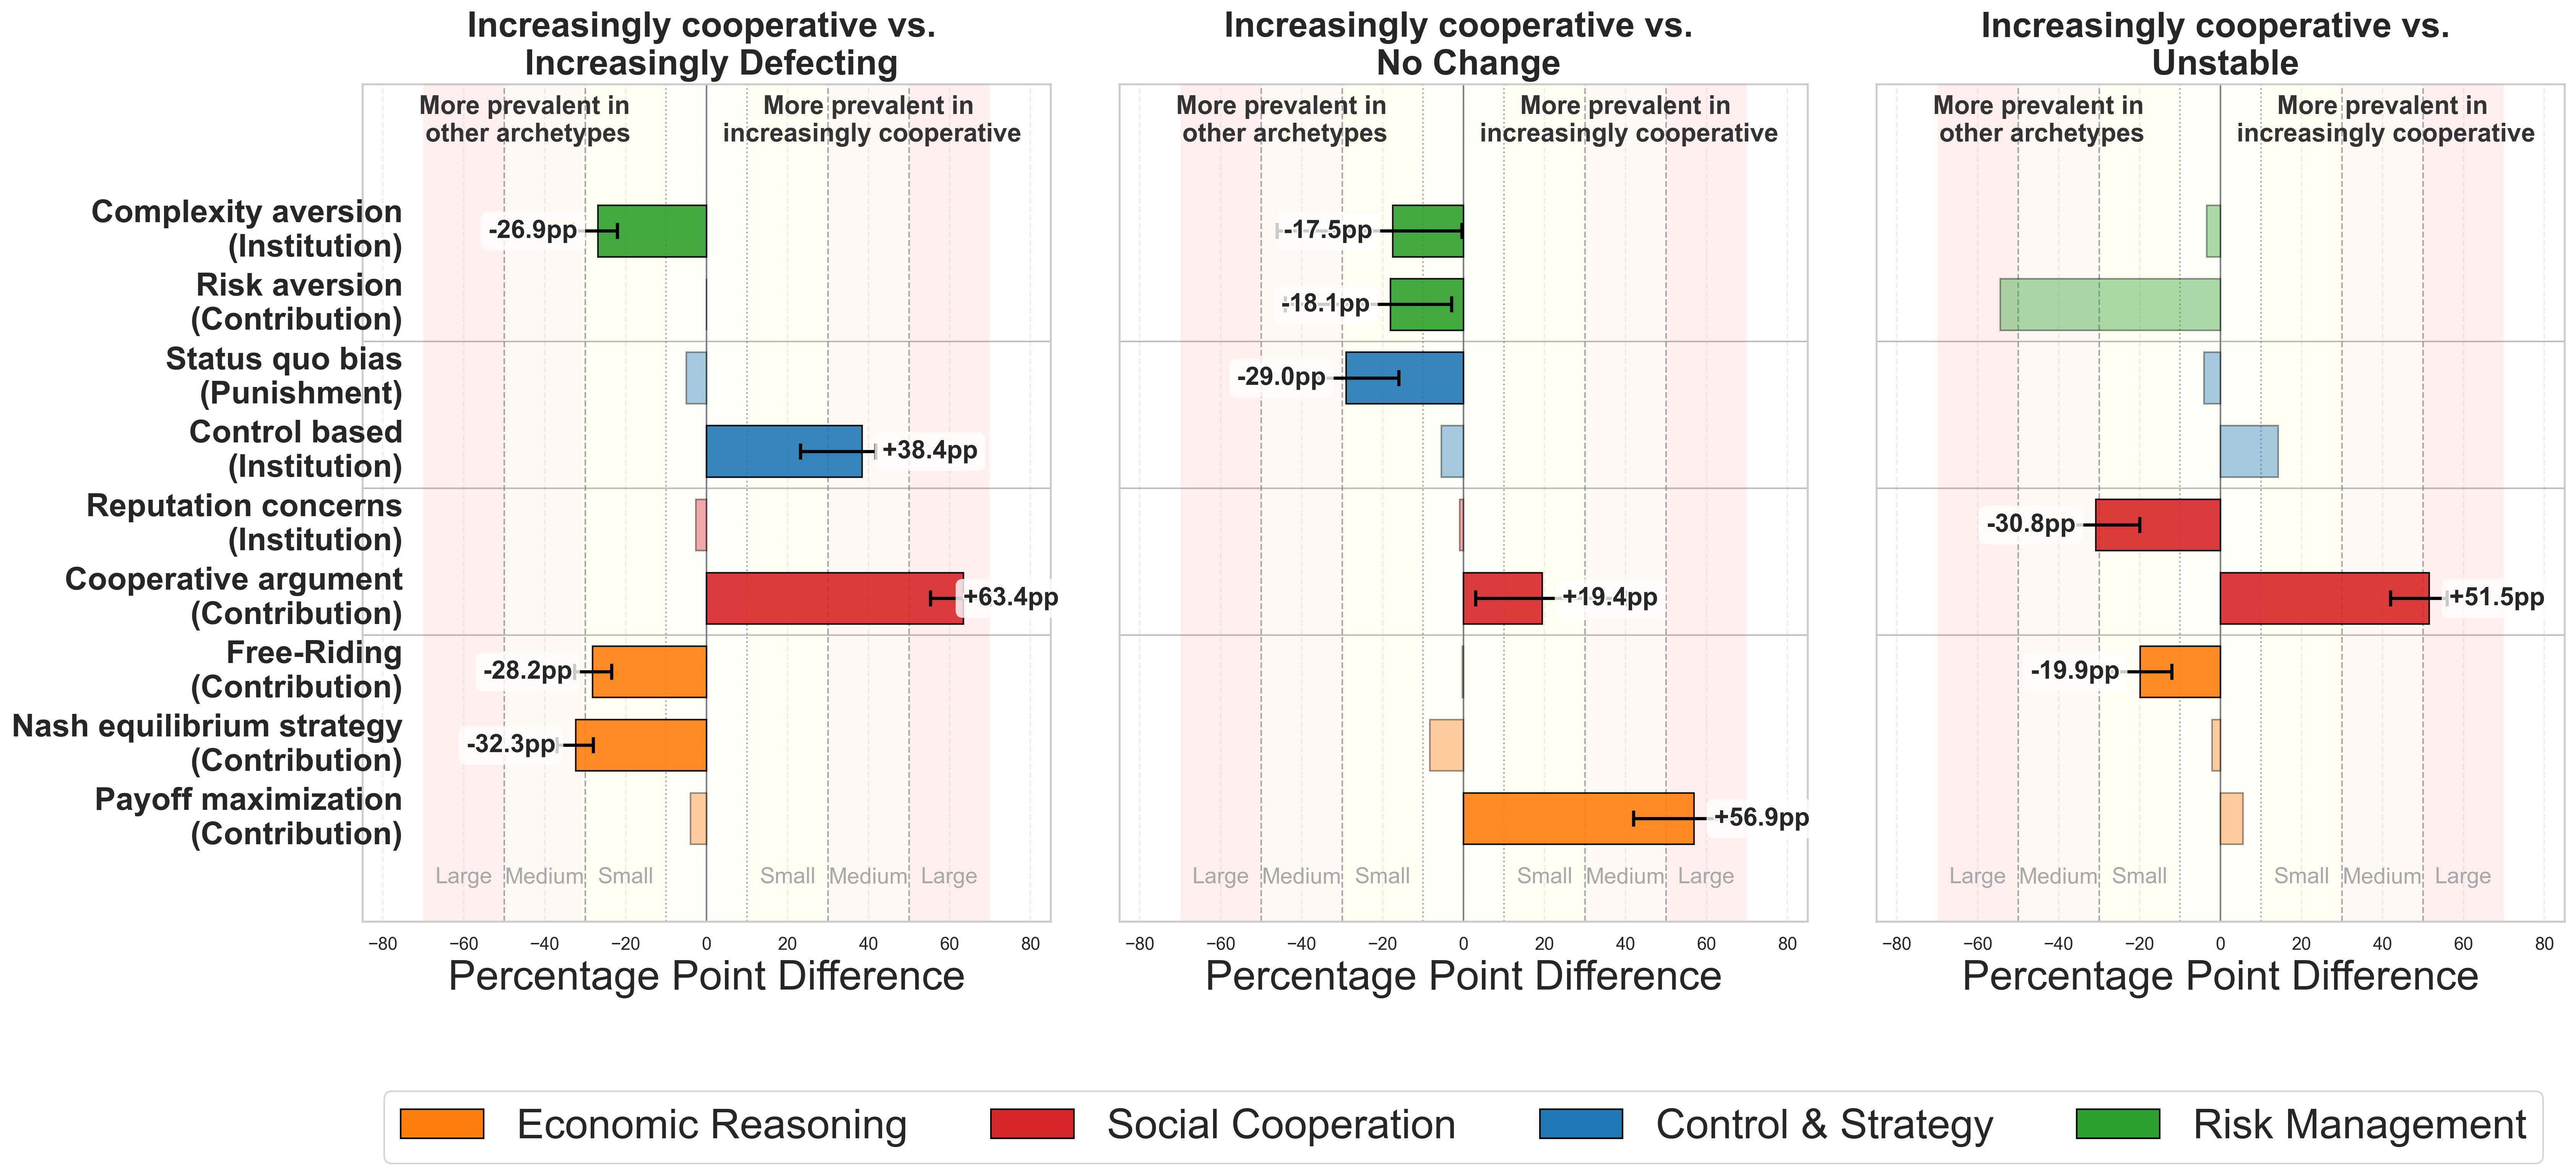

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import matplotlib.patheffects as path_effects

# Create data for archetype comparisons with percentages
archetype_data = pd.DataFrame({
    'SubCategory': [
        'Cooperative argument',      # Most significant difference
        'Payoff maximization',       # Large difference
        'Free-Riding',               # Large difference
        'Nash equilibrium strategy', # Medium difference
        'Risk aversion',             # Medium difference
        'Complexity aversion',       # Medium difference
        'Status quo bias',           # Medium difference
        'Control based',             # Medium difference
        'Reputation concerns'        # Medium difference
    ],
    'MainCategory': [
        'Social Cooperation',
        'Economic Reasoning',
        'Economic Reasoning',
        'Economic Reasoning',
        'Risk Management',
        'Risk Management',
        'Control & Strategy',
        'Control & Strategy',
        'Social Cooperation'
    ],
    
    # Raw percentages for Increasingly cooperative
    'Institution_pct_inc_cooperative': [83.1, 94.2, 2.9, 2.4, 5.8, 0.4, 0.8, 68.5, 2.5],
    'Contribution_pct_inc_cooperative': [91.5, 84.5, 0.1, 3.6, 13.2, 0.2, 4.3, 24.4, 1.8],
    'Punishment_pct_inc_cooperative': [91.2, 20.9, 0.5, 0.7, 35.0, 3.1, 3.6, 34.9, 1.2],
    
    # Raw percentages for Increasingly defecting
    'Institution_pct_defecting': [28.7, 94.2, 20.4, 6.2, 36.7, 27.3, 5.0, 30.1, 5.2],
    'Contribution_pct_defecting': [28.1, 88.5, 28.3, 35.9, 13.2, 0.5, 7.3, 13.0, 1.6],
    'Punishment_pct_defecting': [82.6, 11.6, 1.2, 1.8, 34.9, 8.2, 8.6, 52.3, 3.5],
    
    # Raw percentages for No change
    'Institution_pct_nochange': [72.8, 43.6, 3.2, 7.5, 32.8, 17.9, 8.5, 74.0, 3.5],
    'Contribution_pct_nochange': [72.1, 27.6, 0.4, 11.9, 31.3, 5.0, 12.9, 30.1, 2.2],
    'Punishment_pct_nochange': [85.8, 2.1, 0.8, 7.5, 45.6, 24.3, 32.6, 54.6, 2.8],
    
    # Raw percentages for Unstable
    'Institution_pct_unstable': [85.7, 92.4, 3.8, 2.9, 34.3, 3.8, 1.9, 54.3, 33.3],
    'Contribution_pct_unstable': [40.0, 79.0, 20.0, 5.7, 67.6, 1.9, 2.9, 4.8, 2.9],
    'Punishment_pct_unstable': [87.2, 17.9, 0.0, 2.6, 33.0, 10.3, 7.7, 38.5, 2.6],
})

# Calculate percentage differences for each archetype and decision type
for archetype in ['defecting', 'nochange', 'unstable']:
    for decision in ['Institution', 'Contribution', 'Punishment']:
        archetype_data[f'{decision}_pct_diff_{archetype}'] = (
            archetype_data[f'{decision}_pct_inc_cooperative'] - 
            archetype_data[f'{decision}_pct_{archetype}']
        )

# Add confidence intervals for percentages (as available from the bootstrapping)
# CI for Increasingly defecting
archetype_data['Institution_CI_lower_defecting'] = [39.9, -6.0, -21.8, -5.4, -36.0, -33.0, -6.7, 23.2, -5.0]
archetype_data['Institution_CI_upper_defecting'] = [66.2, 6.0, -14.0, -2.0, -13.3, -22.0, -3.0, 41.8, -1.0]
archetype_data['Contribution_CI_lower_defecting'] = [55.3, -14.0, -32.6, -37.0, -7.0, -0.5, -4.0, -5.0, -2.0]
archetype_data['Contribution_CI_upper_defecting'] = [73.3, 4.0, -23.5, -28.0, 10.0, 0.0, 3.0, 15.0, 1.0]
archetype_data['Punishment_CI_lower_defecting'] = [-6.0, -1.0, -1.5, -2.0, -12.0, -10.0, -10.0, -42.0, -5.0]
archetype_data['Punishment_CI_upper_defecting'] = [22.0, 20.0, 0.1, 0.0, 12.0, 2.0, 0.0, 3.0, 1.0]

# CI for No change
archetype_data['Institution_CI_lower_nochange'] = [-16.0, 30.0, -2.5, -8.0, -59.0, -46.0, -15.5, -42.0, -3.0]
archetype_data['Institution_CI_upper_nochange'] = [15.0, 68.0, 0.5, -3.0, -3.0, -0.4, -3.0, 26.0, 2.0]
archetype_data['Contribution_CI_lower_nochange'] = [3.0, 42.0, -0.5, -8.0, -44.0, -12.0, -22.0, -21.0, -2.0]
archetype_data['Contribution_CI_upper_nochange'] = [40.0, 77.0, 0.0, -1.0, -3.0, -4.0, -1.0, 13.0, 1.0]
archetype_data['Punishment_CI_lower_nochange'] = [-19.0, 9.0, -1.0, -11.0, -22.0, -33.0, -39.0, -29.0, -3.0]
archetype_data['Punishment_CI_upper_nochange'] = [10.0, 23.0, 0.3, -6.0, 0.0, -21.0, -16.0, -13.0, 1.0]

# CI for Unstable
archetype_data['Institution_CI_lower_unstable'] = [-15.0, -8.0, -2.0, -2.0, -36.0, -7.0, -1.5, -6.0, -37.0]
archetype_data['Institution_CI_upper_unstable'] = [3.0, 12.0, 2.0, 1.5, -12.0, 0.0, 0.5, 20.0, -20.0]
archetype_data['Contribution_CI_lower_unstable'] = [42.0, -8.0, -28.0, -3.0, -64.0, -4.0, -0.5, 11.0, -3.0]
archetype_data['Contribution_CI_upper_unstable'] = [56.0, 13.0, -12.0, 2.0, 9.0, 0.0, 3.0, 25.0, 1.0]
archetype_data['Punishment_CI_lower_unstable'] = [-2.0, -3.0, -0.5, -3.0, -5.0, -10.0, -7.0, -10.0, -3.0]
archetype_data['Punishment_CI_upper_unstable'] = [8.0, 11.0, 1.0, 0.0, 9.0, 0.0, 0.0, 3.0, 1.0]

# Determine which decision type has the maximum absolute difference for each subcategory
max_decision_types = []
for _, row in archetype_data.iterrows():
    max_abs_diff = 0
    max_decision = None
    
    # Check all decision types and all archetypes
    for decision in ['Institution', 'Contribution', 'Punishment']:
        for archetype in ['defecting', 'nochange', 'unstable']:
            diff = abs(row[f'{decision}_pct_diff_{archetype}'])
            if diff > max_abs_diff:
                max_abs_diff = diff
                max_decision = decision
    
    max_decision_types.append(max_decision)

archetype_data['max_decision_type'] = max_decision_types

# Calculate maximum absolute difference for each subcategory
archetype_data['max_abs_diff'] = archetype_data.apply(
    lambda row: max([
        abs(row[f"{row['max_decision_type']}_pct_diff_defecting"]),
        abs(row[f"{row['max_decision_type']}_pct_diff_nochange"]),
        abs(row[f"{row['max_decision_type']}_pct_diff_unstable"])
    ]),
    axis=1
)

# Organize by macro category, then by effect size within each category
grouped_data = []
for category in ['Economic Reasoning', 'Social Cooperation', 'Control & Strategy', 'Risk Management']:
    category_data = archetype_data[archetype_data['MainCategory'] == category].copy()
    # Sort by max_abs_diff within each category
    category_data = category_data.sort_values(by='max_abs_diff', ascending=False)
    grouped_data.append(category_data)

# Combine back into a single DataFrame
archetype_data = pd.concat(grouped_data).reset_index(drop=True)

# Set up the figure with a higher DPI for better quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 22  # Base font size

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True, gridspec_kw={'wspace': 0.1})  # Increased spacing between subplots to prevent overlap
archetypes = ['defecting', 'nochange', 'unstable']
archetype_titles = {
    'defecting': 'Increasingly Defecting',
    'nochange': 'No Change',
    'unstable': 'Unstable'
}

# Define main category colors for bars
main_colors = {
    'Control & Strategy': '#1F77B4',  # Blue
    'Economic Reasoning': '#FF7F0E',  # Orange
    'Risk Management': '#2CA02C',     # Green
    'Social Cooperation': '#D62728'   # Red
}

# Define percentage difference background colors
pct_diff_colors = {
    'large': '#ffcccc',   # Light red
    'medium': '#ffeedd',  # Light orange
    'small': '#ffffdd',   # Light yellow
}

# Count total subcategories
n_subcategories = len(archetype_data)

# Add horizontal lines between categories
category_dividers = []
current_category = None
for i, row in archetype_data.iterrows():
    if row['MainCategory'] != current_category:
        if i > 0:  # Don't add divider at the top
            category_dividers.append(i - 0.5)
        current_category = row['MainCategory']

# Visual cap for bar length (in percentage points)
visual_cap = 70

# Function to create color with varying intensity based on percentage difference
def get_color_with_intensity(base_color, pct_diff):
    # Convert percentage difference to a value between 0.4 (weak) and 1.0 (strong)
    intensity = min(1.0, 0.4 + 0.6 * min(1.0, abs(pct_diff) / visual_cap))
    
    # Get the base color and adjust its alpha
    rgba = to_rgba(base_color)
    return (rgba[0], rgba[1], rgba[2], intensity)

for i, archetype in enumerate(archetypes):
    ax = axes[i]
    
    # Add background color bands for percentage difference ranges
    ax.axvspan(50, visual_cap, facecolor=pct_diff_colors['large'], alpha=0.3, zorder=0)
    ax.axvspan(30, 50, facecolor=pct_diff_colors['medium'], alpha=0.3, zorder=0)
    ax.axvspan(10, 30, facecolor=pct_diff_colors['small'], alpha=0.3, zorder=0)
    ax.axvspan(-10, 10, facecolor=pct_diff_colors['small'], alpha=0.15, zorder=0)
    ax.axvspan(-30, -10, facecolor=pct_diff_colors['small'], alpha=0.3, zorder=0)
    ax.axvspan(-50, -30, facecolor=pct_diff_colors['medium'], alpha=0.3, zorder=0)
    ax.axvspan(-visual_cap, -50, facecolor=pct_diff_colors['large'], alpha=0.3, zorder=0)
    
    # Draw reference lines
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, zorder=1)
    ax.axvline(x=10, color='darkgray', linestyle=':', linewidth=1, zorder=1)
    ax.axvline(x=30, color='darkgray', linestyle='--', linewidth=1, zorder=1)
    ax.axvline(x=50, color='darkgray', linestyle='--', linewidth=1, zorder=1)
    ax.axvline(x=-10, color='darkgray', linestyle=':', linewidth=1, zorder=1)
    ax.axvline(x=-30, color='darkgray', linestyle='--', linewidth=1, zorder=1)
    ax.axvline(x=-50, color='darkgray', linestyle='--', linewidth=1, zorder=1)
    
    # Draw horizontal lines between main categories
    for divider in category_dividers:
        ax.axhline(y=divider, color='gray', linestyle='-', linewidth=1, alpha=0.5, zorder=1)
    
    # Plot each subcategory
    for j in range(n_subcategories):
        row = archetype_data.iloc[j]
        decision = row['max_decision_type']
        
        # Get the percentage difference for this archetype and the max decision type
        pct_diff = row[f'{decision}_pct_diff_{archetype}']
        ci_lower = row[f'{decision}_CI_lower_{archetype}']
        ci_upper = row[f'{decision}_CI_upper_{archetype}']
        
        # Get raw percentages for labels
        pct_inc_cooperative = row[f'{decision}_pct_inc_cooperative']
        pct_other = row[f'{decision}_pct_{archetype}']
        
        # Check if confidence interval crosses zero (non-significant)
        is_not_significant = (ci_lower <= 0 and ci_upper >= 0)
        
        # Only make translucent if effect is small OR not significant
        is_small_effect = abs(pct_diff) < 10
        alpha = 0.4 if (is_small_effect or is_not_significant) else 0.9
        
        # Set bar color based on main category
        bar_color = main_colors[row['MainCategory']]
        
        # Calculate capped percentage difference for visualization
        capped_pct_diff = max(min(pct_diff, visual_cap), -visual_cap)
        
        # Check if percentage difference exceeds the cap
        exceeds_cap = abs(pct_diff) > visual_cap
        
        # Draw the bar
        bar = ax.barh(
            j, 
            capped_pct_diff, 
            height=0.7,
            color=bar_color,
            edgecolor='black',
            linewidth=1.0,
            zorder=2,
            alpha=alpha
        )
        
        # Add 'cap exceeded' indicator for values that go beyond the visual cap
        if exceeds_cap:
            cap_x = visual_cap if pct_diff > 0 else -visual_cap
            ax.scatter(
                cap_x, 
                j, 
                marker='>' if pct_diff > 0 else '<',
                s=120,  # INCREASED size
                color='black', 
                zorder=4
            )
        
        # Add error bars for confidence intervals (for significant effects that aren't small)
        if not is_small_effect and not is_not_significant:
            # Calculate capped confidence intervals for visualization
            capped_ci_lower = max(min(ci_lower, visual_cap), -visual_cap)
            capped_ci_upper = max(min(ci_upper, visual_cap), -visual_cap)
            
            # Calculate error bar widths - must be positive for matplotlib
            left_error = abs(capped_pct_diff - capped_ci_lower)
            right_error = abs(capped_ci_upper - capped_pct_diff)
            
            ax.errorbar(
                x=capped_pct_diff, 
                y=j,
                xerr=[[left_error], [right_error]], 
                fmt='none',
                ecolor='black',
                capsize=5,  # INCREASED size
                capthick=2,  # INCREASED thickness
                elinewidth=2,  # INCREASED thickness
                zorder=3
            )
        
        # Add text label for medium to large percentage differences (|diff| >= 10%)
        # AND only if statistically significant
        if abs(pct_diff) >= 10 and not is_not_significant:
            # Position label outside the bar
            offset = 5
            if pct_diff > 0:
                label_x = min(pct_diff + offset, visual_cap + offset)
                ha_alignment = 'left'
            else:
                label_x = max(pct_diff - offset, -visual_cap - offset)
                ha_alignment = 'right'
            
            # Format label to show percentage difference only
            label_text = f"{pct_diff:+.1f}pp" 
            
            # Fix for overlap issues - ensure wide enough spacing
            if pct_diff > 55 and decision == 'Contribution' and row['SubCategory'] == 'Cooperative argument':
                # Special case for the "+63.4pp" label that's overlapping
                label_x = min(pct_diff, visual_cap - 5)  # Pull the label in a bit to avoid overlap
                fontsize = 16  # Slightly smaller for this specific label
            else:
                fontsize = 16  # Slightly smaller than 18 to help with spacing
            
            # Create text with white outline for better visibility
            text = ax.text(
                label_x, 
                j, 
                label_text, 
                ha=ha_alignment,
                va='center', 
                fontsize=fontsize,
                fontweight='bold', 
                zorder=4,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
            )
            
            # Add white outline to text for better visibility
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='white'),
                path_effects.Normal()
            ])
    
    # Add category labels to the y-axis (only for the first panel)
    if i == 0:
        
        # Add subcategory labels with decision type
        for j in range(n_subcategories):
            row = archetype_data.iloc[j]
            decision = row['max_decision_type']
            
            # Create the subcategory label with decision type in parentheses
            label_text = f"{row['SubCategory']}\n({decision})"
            
            ax.text(
                -visual_cap - 5, 
                j, 
                label_text,
                ha='right',
                va='center',
                fontsize=20,  # INCREASED from 15 to 20
                fontweight='bold'
            )
    
    # Add percentage difference labels at the bottom
    ax.text(60, -0.8, "Large", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    ax.text(40, -0.8, "Medium", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    ax.text(20, -0.8, "Small", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    ax.text(-20, -0.8, "Small", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    ax.text(-40, -0.8, "Medium", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    ax.text(-60, -0.8, "Large", ha='center', va='center', fontsize=14, color='darkgray')  # Middle ground between 14 and 18
    
    # Add directional indicators at the top - MODIFIED TO PREVENT OVERLAP
    ax.annotate('More prevalent in\n other archetypes', xy=(-60, n_subcategories + 0.5), xytext=(-45, n_subcategories + 0.5), 
                fontsize=16, ha='center', va='center', color='#333333', fontweight='bold')  # Moved farther left to prevent overlap
    
    ax.annotate('More prevalent in\n increasingly cooperative', xy=(60, n_subcategories + 0.5), xytext=(40, n_subcategories + 0.5), 
                fontsize=16, ha='center', va='center', color='#333333', fontweight='bold')  # Moved farther right to prevent overlap
    
    # Set title and axis labels
    ax.set_title(f"Increasingly cooperative vs. \n {archetype_titles[archetype]}", fontsize=22, fontweight='bold')  # Reverted to original size
    ax.set_xlabel("Percentage Point Difference", fontsize=26)  # Kept increased size for axis label
    
    # Set axis limits with extra space for labels
    ax.set_xlim(-visual_cap - 15, visual_cap + 15)
    ax.set_ylim(-1.4, n_subcategories + 1.0)
    
    # Remove y-ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Add grid for readability
    ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)

# Add legend for main categories
legend_elements = [
    patches.Patch(facecolor=main_colors['Economic Reasoning'], edgecolor='black', label='Economic Reasoning'),
    patches.Patch(facecolor=main_colors['Social Cooperation'], edgecolor='black', label='Social Cooperation'),
    patches.Patch(facecolor=main_colors['Control & Strategy'], edgecolor='black', label='Control & Strategy'),
    patches.Patch(facecolor=main_colors['Risk Management'], edgecolor='black', label='Risk Management')
]

fig.legend(
    handles=legend_elements, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.02), 
    ncol=4,
    frameon=True, 
    fontsize=26  # INCREASED from 18 to 22
)

# Tight layout for better spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, left=0.1)

# Save as PNG and PDF
plt.savefig('archetype_percentage_differences.png', dpi=300, bbox_inches='tight')
plt.savefig('archetype_percentage_differences.pdf', format='pdf', bbox_inches='tight')

plt.show()